# Tutorial: Implement your own Riemannian Geometry

Geomstats provides several Riemannian manifolds in its `geometry` folder. Yet, the manifold that you are interested in might not be available there.

This notebook shows how to use Riemannian geometry on any manifold defined by an immersion into a Euclidean space, such as high-dimensional surfaces immersed in a Euclidean space. 

Specifically, we focus on the case of an embedded manifold $M$ that can be defined by a map f:
$f: M \rightarrow \mathbb{R}^n$ 
called the immersion, whose differential $df_x$ is injective for all $x \in M$.

This immersion allows to define the pull-back metric $g$ on $M$, as:
$$g : T_xM \times T_x M \rightarrow \mathbb{R}\\
u, v \rightarrow <df_x.u, df_x.v>$$
where $<,>$ represents the Euclidean inner-product of the embedding space. 

The pull-back metric gives a structure of Riemannian manifold to $M$. In particular, we can compute the Riemannian exp and log maps, the Riemannian distance, the Riemannian parallel transport, etc.

This notion illustrates the computation of the pull-back metric, using the class `PullbackMetric` from geomstats, on two embedded manifolds:
- the 2-sphere $S^2$ embedded in $\mathbb{R}^3$,
- a surface defined by: $x, y \rightarrow z = x^2 + y^2$ embedded in $\mathbb{R}^3$.

## Setup

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

import geomstats.visualization as viz

INFO: Using pytorch backend


In [3]:
import geomstats.backend as gs

We import the main structure used in this notebook: the `PullbackMetric`:

In [4]:
from geomstats.geometry.pullback_metric import PullbackMetric

## Immersed manifolds: the example of the 2-sphere

We first consider the simple example of the 2-sphere. We define the immersion of the 2-sphere $S^2$ into the Euclidean space $\mathbb{R}^3$ as follows:
$$f : S^2 \rightarrow \mathbb{R}^3\\
(\theta, \phi) \rightarrow (\cos\phi.\sin\theta, \sin\phi.\sin\theta, \cos\theta)$$

In [5]:
def sphere_immersion(spherical_coords):
    theta = spherical_coords[..., 0]
    phi = spherical_coords[..., 1]
    return gs.array([
        gs.cos(phi) * gs.sin(theta),
        gs.sin(phi) * gs.sin(theta),
        gs.cos(theta)])

For the purpose of visualizing the results in the embedding space $\mathbb{R}^3$, we will need the jacobian of the immersion, which we compute here:

In [6]:
jac_sphere_immersion = gs.autograd.jacobian(sphere_immersion)

We use the `PullbackMetric` structure to define the Riemannian metric on $S^2$ from the immersion. 

Note that the Riemannian metric on the sphere is already implemented in Geomstats using closed forms with the class `Hypersphere`. However, this notebook showcases how we can recover the computations of Riemanian geometry by only relying on the immersion.

In [7]:
sphere_metric = PullbackMetric(dim=2, embedding_dim=3, immersion=sphere_immersion)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We first show the computation of the Riemannian exp map of a tangent vector at a point.

In [8]:
point_a = gs.array([gs.pi / 2. , - gs.pi / 2.])
tangent_vec = gs.array([0., gs.pi / 3.])

end_point = sphere_metric.exp(
    tangent_vec=tangent_vec, base_point=point_a)

And visualize the result of the Riemannian exp map in the embedding space $\mathbb{R}^3$:

<IPython.core.display.Javascript object>


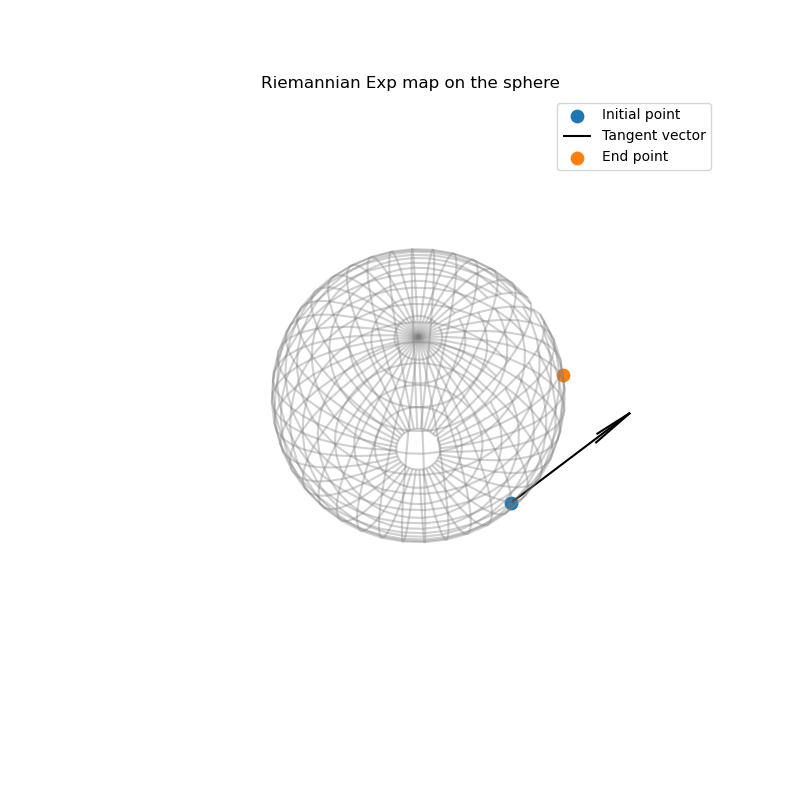

In [9]:
%matplotlib notebook

# We immerse the points and the tangent vector in R^3

immersed_point_a = sphere_immersion(point_a)
immersed_tangent_vec = gs.matmul(jac_sphere_immersion(point_a), tangent_vec)
immersed_end_point = sphere_immersion(end_point)

# We plot our results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

viz.plot(
    immersed_point_a, ax=ax, space='S2', label='Initial point', s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color='black', label="Tangent vector")

viz.plot(
    immersed_end_point, ax=ax, space='S2', label='End point', s=80)

ax.set_title('Riemannian Exp map on the sphere')
ax.legend()
ax.grid(False)
plt.axis('off');

Next, we show the computation of the parallel transport on the sphere.

In [10]:
point_a = gs.array([gs.pi / 2. , - gs.pi / 2.])
tangent_vec = gs.array([0., gs.pi / 3.])
tangent_vec_to_transport = gs.array([gs.pi / 4., gs.pi / 3.])

parallel_transport = sphere_metric.ladder_parallel_transport(
    tangent_vec_a=tangent_vec_to_transport, 
    tangent_vec_b=tangent_vec,
    base_point=point_a)

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

{'transported_tangent_vec': tensor([0.7854, 1.0472]),
 'end_point': tensor([ 1.5708, -0.5236]),
 'trajectory': [[]]}

We visualize the result of the parallel transport in the embedding space $\mathbb{R}^3$:

is_tangent =  tensor(True)


<IPython.core.display.Javascript object>


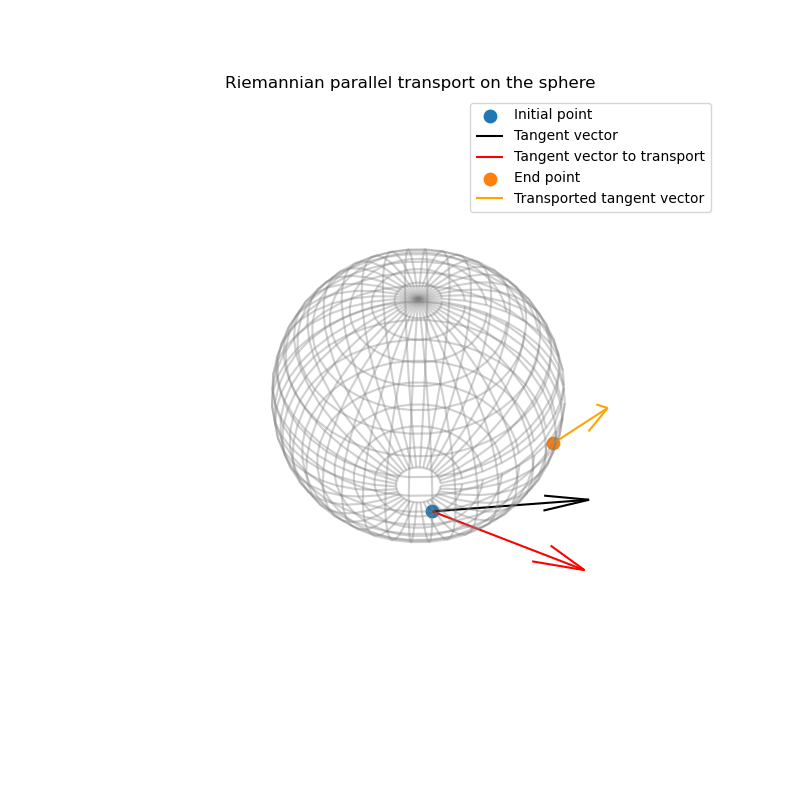

In [11]:
%matplotlib notebook


# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = sphere_immersion(point_a)
immersed_end_point = sphere_immersion(end_point)

immersed_tangent_vec = gs.matmul(
    jac_sphere_immersion(point_a), tangent_vec)
immersed_tangent_vec_to_transport = gs.matmul(
    jac_sphere_immersion(point_a), tangent_vec_to_transport)
immersed_transported_tangent_vec = gs.matmul(
    jac_sphere_immersion(end_point), transported_tangent_vec)

# We verify manually that the immersed tangent vector is actually tangent to the sphere
# as the plot can be sometimes misleading
#from
is_tangent = gs.isclose(
    gs.dot(immersed_transported_tangent_vec, immersed_end_point), 0.)
print("is_tangent = ", is_tangent)

# We plot the results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

viz.plot(
    immersed_point_a, ax=ax, space='S2', label='Initial point', s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color='black', label="Tangent vector")

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color='red', label="Tangent vector to transport")

viz.plot(
    immersed_end_point, ax=ax, space='S2', label='End point', s=80)

arrow = viz.Arrow3D(immersed_end_point, vector=immersed_transported_tangent_vec)
arrow.draw(ax, color='orange', label="Transported tangent vector")

ax.set_title('Riemannian parallel transport on the sphere')
ax.legend()
ax.grid(False)
plt.axis('off');

## Immersed manifolds: the example of a surface defined by its graph

We consider the example of a 2D surface immersed in $\mathbb{R}^3$. The surface is defined by its graph:
$$ x, y \rightarrow z = x^2 + y^2$$
which leads to the following immersion into $\mathbb{R}^3$:
$$f : S^2 \rightarrow \mathbb{R}^3\\
(x, y) \rightarrow (x, y, x^2 + y^2)$$

We first implement the graph and the immersion:

In [13]:
def surface_graph(x, y):
    return x ** 2 + y ** 2

def surface_immersion(intrinsic_coords):
    x = intrinsic_coords[..., 0]
    y = intrinsic_coords[..., 1]
    return gs.transpose(gs.array([x, y, surface_graph(x, y)]))

For the purpose of visualizing the results in the embedding space  ℝ3 , we will need the jacobian of the immersion, which we compute here:

In [14]:
jac_surface_immersion = jacobian(surface_immersion)

We also add a utility function to visualization the surface in 3D:

<IPython.core.display.Javascript object>


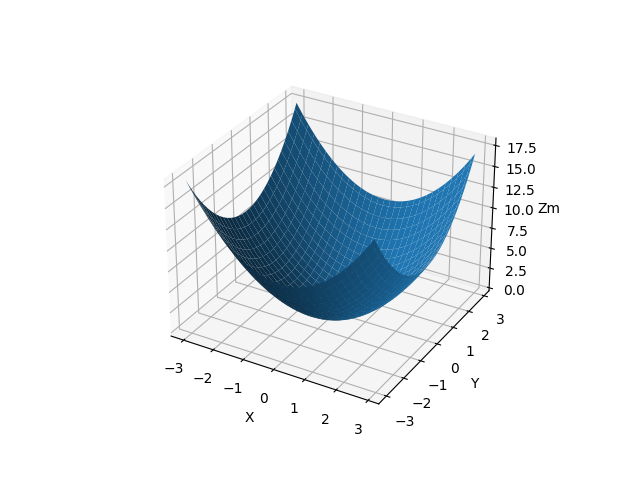

In [15]:
%matplotlib notebook

def plot_surface(alpha=1., ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    x = y = gs.arange(-3.0, 3.0, 0.1)
    X, Y =gs.meshgrid(x, y)
    zs = gs.array(surface_graph(gs.flatten(X), gs.flatten(Y)))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, alpha=alpha)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Zm')
    plt.show()
    return ax

_ = plot_surface()
ax.grid(False)
plt.axis('off');

We use the `PullbackMetric` structure to define the Riemannian metric on the surface from the immersion. 

In [16]:
surface_metric = PullbackMetric(dim=2, embedding_dim=3, immersion=surface_immersion)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We show the computation of the Riemannian exp map:

In [17]:
point_a = gs.array([-2. , - 2.])
tangent_vec = gs.array([0., 1.])

end_point = surface_metric.exp(
    tangent_vec=tangent_vec, base_point=point_a)

And visualize the result:

<IPython.core.display.Javascript object>


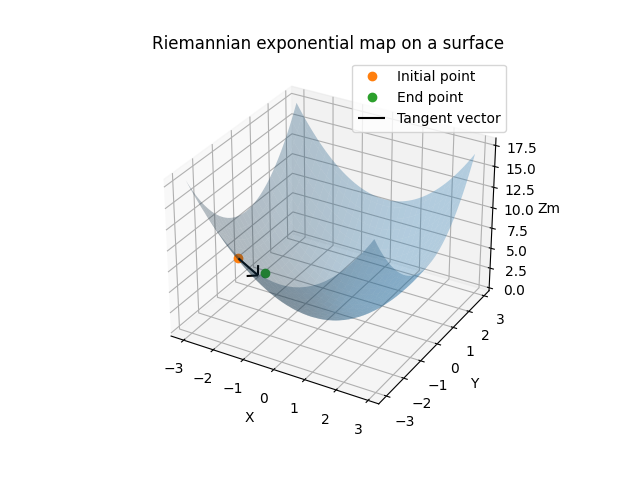

In [18]:
%matplotlib notebook

# We first immerse the points and tangent vector into the embedding space R^3

immersed_point_a = surface_immersion(point_a)
immersed_tangent_vec = gs.matmul(jac_surface_immersion(point_a), tangent_vec)
immersed_end_point = surface_immersion(end_point)

two_points = gs.vstack([immersed_point_a, immersed_end_point])

# We plot the results

ax = plot_surface(alpha=0.3)

ax.plot(
    immersed_point_a[0], 
    immersed_point_a[1], 
    immersed_point_a[2], 
    label='Initial point', marker="o", linestyle = 'None')

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color='black', label="Tangent vector")

ax.plot(
    immersed_end_point[0], 
    immersed_end_point [1], 
    immersed_end_point [2], 
    label='End point', marker="o", linestyle = 'None')

ax.set_title('Riemannian exponential map on a surface')
ax.legend()
ax.grid(False)
plt.axis('off');

Next, we show the computation of the parallel transport on the surface.

In [19]:
point_a = gs.array([-2. , 2.])
tangent_vec = gs.array([-2., -2.])
tangent_vec_to_transport = gs.array([-.6, .6])

parallel_transport = surface_metric.ladder_parallel_transport(
    tangent_vec_a=tangent_vec_to_transport, 
    tangent_vec_b=tangent_vec,
    base_point=point_a)

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

{'transported_tangent_vec': array([-0.89744937,  0.60633899]),
 'end_point': array([-2.94546601, -0.60385116]),
 'trajectory': [[]]}

We visualize the result of the parallel transport.

<IPython.core.display.Javascript object>


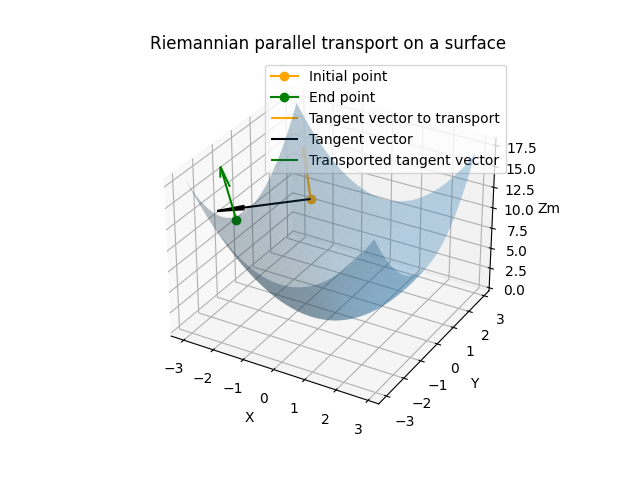

In [20]:
%matplotlib notebook

# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = surface_immersion(point_a)
immersed_tangent_vec = gs.matmul(
    jac_surface_immersion(point_a), tangent_vec)
immersed_tangent_vec_to_transport = gs.matmul(
    jac_surface_immersion(point_a), tangent_vec_to_transport)
immersed_end_point = surface_immersion(end_point)
immersed_transported_tangent_vec = gs.matmul(
    jac_surface_immersion(end_point), transported_tangent_vec)

# We plot the results

ax = plot_surface(alpha=0.3)

ax.plot(
    immersed_point_a[0], 
    immersed_point_a[1], 
    immersed_point_a[2], 
    label='Initial point', marker="o", color="orange")

arrow = viz.Arrow3D(
    immersed_point_a, 
    vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color="orange", label="Tangent vector to transport")

arrow = viz.Arrow3D(
    immersed_point_a, 
    vector=immersed_tangent_vec)
arrow.draw(ax, color='black', label="Tangent vector")

ax.plot(
    immersed_end_point[0], 
    immersed_end_point[1], 
    immersed_end_point[2], 
    label='End point', marker="o", color="green")


arrow = viz.Arrow3D(
    immersed_end_point, 
    vector=immersed_transported_tangent_vec)
arrow.draw(ax, color='green', label="Transported tangent vector")

ax.set_title('Riemannian parallel transport on a surface')
ax.legend()
ax.grid(False)
plt.axis('off');